In [2]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.data import Collector, VectorReplayBuffer
from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.trainer import offpolicy_trainer
from LCRL.utils import TensorboardLogger
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic, ActorProb
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

# NOTE: This notebook is used after training our new reach-avoid value function via SAC

"""
    Note that, we can train our new reach-avoid value function via SAC
    python run_training_sac.py --task ra_highway_Game-v2 --control-net 512 512 512 --disturbance-net 512 512 512 --critic-net 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160   
"""

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_highway_Game-v2')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.0)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512]*3) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512]*3) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512]*3) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=False) # True -> annealed reach-avoid Bellman equation, False -> our new reach-rl Bellman equation
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    parser.add_argument('--warm-start-path', type=str, default=None)
    # new sac params:
    parser.add_argument('--alpha', default = 0.2) 
    parser.add_argument('--auto-alpha', type=int, default=1)
    parser.add_argument('--alpha-lr', type=float, default=3e-4)
    args = parser.parse_known_args()[0]
    return args



args=get_args()


env = gym.make(args.task)
# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

args.action1_shape = env.action1_space.shape or env.action1_space.n
args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
args.max_action2 = env.action2_space.high[0]


# you can also use tianshou.env.SubprocVectorEnv
# train_envs = gym.make(args.task)
train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
# test_envs = gym.make(args.task)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    # report error:
    raise ValueError("Please provide critic_net!")

# critic = Critic(critic_net, device=args.device).to(args.device)
# critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
# import pdb; pdb.set_trace()
log_path = None

if args.is_game_baseline:
    from LCRL.policy import reach_avoid_game_SACPolicy_annealing as SACPolicy
    print("SAC under the Reach-Avoid annealed Bellman equation has been loaded!")
else:
    from LCRL.policy import reach_avoid_game_SACPolicy as SACPolicy
    print("SAC under the Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = ActorProb(
    actor1_net, 
    args.action1_shape, 
    device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
actor2 = ActorProb(
    actor2_net, 
    args.action2_shape, 
    device=args.device
).to(args.device)
actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)
if args.auto_alpha:
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
    args.alpha = (target_entropy, log_alpha, alpha_optim)

policy = SACPolicy(
critic1,
critic1_optim,
critic2,
critic2_optim,
tau=args.tau,
gamma=args.gamma,
alpha = args.alpha,
exploration_noise= None,#GaussianNoise(sigma=args.exploration_noise), # careful!
deterministic_eval = True,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor2=actor2,
actor2_optim=actor2_optim,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, always true
    args.gamma)
    )
else:
    log_path = os.path.join(args.logdir, args.task, 'sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, # always true
    args.gamma)
    )

log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



SAC under the Reach-RL Bellman equation has been loaded!


In [5]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [8]:
# data reloading module:
epoch_id = 10
envs = gym.make(args.task)
# NOTE! You can define the log path in next line:
# log_path = ""


# check if the log path exists
if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")


policy loaded!


In [9]:
from LCRL.data import Batch


def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

  0%|          | 0/1100 [00:00<?, ?it/s]/tmp/ipykernel_5527/2351683944.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 1100/1100 [02:27<00:00,  7.44it/s]


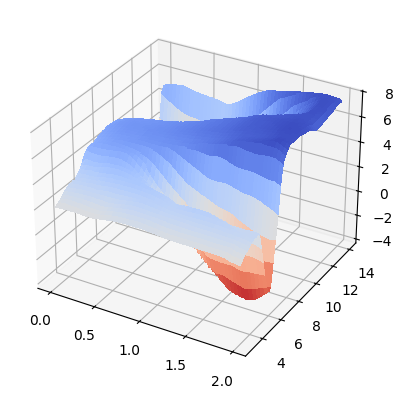

In [10]:
from tqdm import tqdm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'
dx = 0.01
dy = 0.01
min_x = 0
max_x = 2
min_y = 3
max_y = 14
x = np.arange(min_x, max_x, dx)
y = np.arange(min_y, max_y, dy)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))

car1_x = 0.5
car1_y = 13
car1_vy = 1.2
ego_v = 1.6
ego_theta = np.pi/2
car2_x = 1.5
car2_y = 6
car2_vy = 1.2

for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            car1_x, car1_y, car1_vy, 
            X[ii,jj], Y[ii,jj], ego_v, ego_theta,
            car2_x, car2_y, car2_vy
            ])
        V[ii,jj] = evaluate_V( tmp_point )
        
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=False)

In [11]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1
X_pure = X
Y_pure = Y 

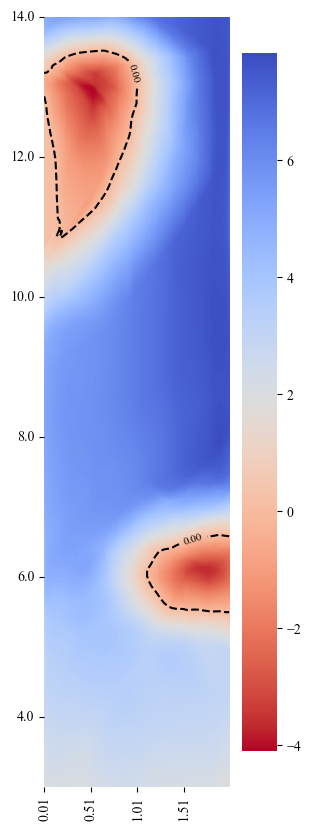

In [14]:
import seaborn as sns

x_interval = 50
y_interval = 200

fig, ax = plt.subplots(figsize=(1.5, 4))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))
x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+dy, 1))

contours = ax.contour((X-min_x)*100, (Y-min_y)*100, V_flipped, levels=[0], colors='black', linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [15]:
# Certification method 1: SOCP certification
def get_nominal_traj(state, horizon):
    env.reset(initial_state = state)
    nominal_traj = np.zeros((10, horizon+1))
    nominal_traj[:,0] = state
    nominal_act = np.zeros((4, horizon))
    constraint_list = np.zeros(horizon+1)
    reach_list = np.zeros(horizon)
    reached = False
    min_constraint = np.Inf
    success = False
    success_time = np.Inf
    for i in range(horizon):
        act = find_a(state)
        act = [act[0], act[1], 0,0]
        state, rew, _, _, info = env.step(act)
        nominal_traj[:,i+1] = state
        nominal_act[:,i] = act
        constraint_list[i] = info['constraint']
        reach_list[i] = rew
        min_constraint = min(min_constraint, info['constraint'])
        if rew > 0 and min_constraint > 0:
            success = True
            success_time = i
            break
    ego_traj = nominal_traj[3:7,:]
    return nominal_traj, ego_traj, nominal_act, constraint_list, reach_list, success, success_time
nominal_traj = get_nominal_traj(np.array([0.5, 18, 0.7, 1.5, 10.0, 2.0, np.pi/2, 1.3, 3, 1]), 21)[-1]

In [18]:
# Fundamental code! using L2 norm bound of the dynamics!
# our efficient solver builds upon clarabel SOCP solver
# clarabel SOCP solver is the fastest SOCP solver I have ever tested!
from scipy import sparse
import clarabel

nx = 10
nd = 2
nu = 2

def qp_reach_avoid_variables(T, dt, epsilon_x, epsilon_d, nx, nu, nd):
    M = None
    N = None
    num_vars = nx * (T+1) + nd * T
    print("number of variables: ", num_vars)
    A = np.eye(nx)
    A[1,2] = -dt
    A[8,9] = dt
    
    B = np.zeros((nx, nu))
    D = np.zeros((nx, nd))
    B[5,0] = dt*2
    B[6,1] = dt*2

    D[2,0] = dt
    D[7,1] = dt
    num_eq = (nx - 2)*T # Mx = N
    M = np.zeros((num_eq, num_vars))
    N = np.zeros((num_eq))
    num_soc = nx*(T+1) + nd*T
    num_ine_x0 = nx
    num_ine_x = nx*(T)
    G_x0 = np.zeros((num_ine_x0 + 1, num_vars))
    H_x0 = np.zeros((num_ine_x0 + 1))
    G_x = np.zeros((num_ine_x + T, num_vars)) # the first row, corresponding to "1", is the right hand side
    H_x = np.zeros((num_ine_x + T))

    num_ine_d = nd*T
    G_d = np.zeros((num_ine_d + T, num_vars))
    H_d = np.zeros((num_ine_d + T))
    assert num_soc ==  num_ine_x0 + num_ine_x + num_ine_d
    G_x0[1:nx+1, 0:nx] = -np.eye(nx) # x0 <= upper

    cones = [
        clarabel.SecondOrderConeT(nx+1)
    ]
    # compute nominal traj:
    x0 = np.array([0.5, 18, 0.7, 0.8, 3.0, 2.0, np.pi/2, 1.3, 7, 1])
    nominal_traj, ego_traj, nominal_act, constraint_list, reach_list, success, success_time = get_nominal_traj(x0, T)
    for t in range(T):
        G_x[t*(nx+1)+1:(t+1)*(nx+1), (t+1)*nx:(t+2)*nx] = -np.eye(nx) # x_{t+1} <= upper
        H_x[t*(nx+1)] = Lf**(t+1) * epsilon_x
        H_x[t*(nx+1)+1:(t+1)*(nx+1)] = -nominal_traj[:,t+1] # -x_{t+1} <= -lower
        cones.append(clarabel.SecondOrderConeT(nx+1))
    for t in range(T):        
        G_d[t*(nd+1)+1:(t+1)*(nd+1), (T+1)*nx+t*nd:(T+1)*nx+(t+1)*nd] = -np.eye(nd) # d_t <= upper
        H_d[t*(nd+1)] = epsilon_d
        cones.append(clarabel.SecondOrderConeT(nd+1))

    G = np.concatenate([G_x0, G_x, G_d])
    H = np.concatenate([H_x0, H_x, H_d])
    zero_sparse_matrix = sparse.csr_matrix((num_vars, num_vars))
    reach_measures = [[np.zeros((num_vars)) for t in range(T)] for i in range(3)] # reachable means: reach_measure * x - reach_offset >0
    reach_offsets = np.zeros(3)
    reach_offsets[0] = 1.
    reach_offsets[1] = 1.
    reach_offsets[2] = 0.2
    num_reach_check = len(reach_measures)
    for t in range(T):
        reach_measures[0][t][t*nx + 3] = 1
        reach_measures[1][t][t*nx + 4] = 1
        reach_measures[1][t][t*nx + 8] = -1
        reach_measures[2][t][t*nx + 5] = 1
        reach_measures[2][t][t*nx + 9] = -1
    prox_measures = [[np.zeros((num_vars, num_vars)) for t in range(T)] for i in range(2)] # proximity means: x' * prox_measure * x - prox_offset >0
    prox_offsets = np.zeros(2)
    prox_offsets[0] = 0.25-1e-6
    prox_offsets[1] = 0.25-1e-6
    for t in range(T):
        prox_measures[0][t][np.ix_(t*nx+np.array([0,1,3,4]), t*nx+np.array([0,1,3,4]))] = np.eye(4)
        prox_measures[0][t][t*nx+0:t*nx+2, t*nx+3:t*nx+5] = -np.eye(2)
        prox_measures[0][t][t*nx+3:t*nx+5, t*nx+0:t*nx+2] = -np.eye(2)  
        prox_measures[0][t] = sparse.csr_matrix(prox_measures[0][t])
        
        prox_measures[1][t][np.ix_(t*nx+np.array([3,4,7,8]), t*nx+np.array([3,4,7,8]))] = np.eye(4)
        prox_measures[1][t][t*nx+3:t*nx+5, t*nx+7:t*nx+9] = -np.eye(2)
        prox_measures[1][t][t*nx+7:t*nx+9, t*nx+3:t*nx+5] = -np.eye(2)
        prox_measures[1][t] = sparse.csr_matrix(prox_measures[1][t])
    G = np.concatenate([G_x0, G_x, G_d])
    return G,G_x, H_x, G_x0, H_x0, G_d, H_d, ego_traj, nominal_act, constraint_list, reach_list, success, success_time, num_vars, num_soc,cones, zero_sparse_matrix, reach_measures, reach_offsets, num_reach_check, prox_measures, prox_offsets
def qp_reach_avoid_checking(delta_x, delta_d, x0, T, dt, G_x0,H_x0, H_x, H_d, G, num_soc,cones, num_vars,
                            prox_measures, prox_offsets, reach_measures, reach_offsets, zero_sparse_matrix, verbose = False):
    nominal_traj, ego_traj, nominal_act, constraint_list, reach_list, success, success_time = get_nominal_traj(x0, T)
    if not success:
        print("not success") if verbose else None
        return False, None
    print("x0: ", x0) if verbose else None
    print("success time: ", success_time) if verbose else None
    H_x0[0] = delta_x
    H_x0[1:nx+1] = -x0
    for t in range(T):
        H_x[t*(nx+1)] = Lf**(t+1) * delta_x
        H_x[t*(nx+1)+1:(t+1)*(nx+1)] = -nominal_traj[:,t+1]
    H = np.concatenate([H_x0, H_x, H_d])
    G = sparse.csc_matrix(G)
    settings = clarabel.DefaultSettings()
    settings.verbose = False
    A = sparse.csc_matrix(G_x0) # equality constraints and inequality constraints
    b = H_x0 # offset of the equality constraints and inequality constraints
    q = np.zeros(num_vars)
    num_prox_check = len(prox_measures)
    num_reach_check = len(reach_measures)
    proximity_list = np.zeros(num_prox_check*T)
    reach_list = np.zeros(num_reach_check*T)
    solver_status = []
    # checking reach avoid
    for t in range(T):
        for i in range(num_prox_check):
            if not prox_measures[i][t].shape[0] == len(q):
                import pdb; pdb.set_trace()
            # print("here")
            print(prox_measures[i][t]) if verbose else None
            obj_scale = 0.01
            solver = clarabel.DefaultSolver(obj_scale*prox_measures[i][t], q, G, H, cones, settings) # G_x0, H_x0, cones, 
            tmp = solver.solve()
            # return True, solver_status
            proximity_list[t*num_prox_check+i] = tmp.obj_val/obj_scale - 0.5*prox_offsets[i]
            solver_status.append(tmp.status)
            if not str(tmp.status) == "Solved":
                print("Solver state: ", tmp.status) if verbose else None
                print("solver failed at t = {} at i = {} with value = {}".format(t, i, proximity_list[t*num_prox_check+i])) if verbose else None
                return False, solver_status
            if proximity_list[t*num_prox_check+i] < 0 - 1e-5:
                print("proximity failed at t = {} at i = {} with value = {}".format(t, i, proximity_list[t*num_prox_check+i])) if verbose else None
                return False, solver_status
        for i in range(num_reach_check):
            obj_scale = 0.1
            solver = clarabel.DefaultSolver(zero_sparse_matrix, obj_scale*reach_measures[i][t], G, H, cones, settings)
            tmp = solver.solve()
            if not str(tmp.status) == "Solved":
                print("reach failed at t = {} at i = {} with value = {}".format(t, i, reach_list[t*num_reach_check+i])) if verbose else None
                return False, solver_status
            reach_list[t*num_reach_check+i] = tmp.obj_val/obj_scale - reach_offsets[i]
            solver_status.append(tmp.status)
            if reach_list[t*num_reach_check+i] < 0:
                print("reach failed at t = {} at i = {} with value = {}".format(t, i, reach_list[t*num_reach_check+i])) if verbose else None
                break
            
        if reach_list[t*num_reach_check:(t+1)*num_reach_check].min() > 0:
            return True, solver_status
        
    return False, solver_status
T = 50
dt = 0.1
epsilon_d = 0.1
epsilon_x = 0.05
Lf = 1.0512
G, G_x, H_x, G_x0, H_x0, G_d, H_d, ego_traj, nominal_act, constraint_list, reach_list, success, success_time, num_vars, num_soc,cones, zero_sparse_matrix, reach_measures, reach_offsets, num_reach_check, prox_measures, prox_offsets = qp_reach_avoid_variables(T, dt,epsilon_x, epsilon_d, nx, nu, nd)
x0 = np.array([
    0.5, 18,1.2, 
    0.7, 13, 2.0, np.pi/2,
    1.8, 7, 1.0
])
tmp_success, tmp_status = qp_reach_avoid_checking(epsilon_x, epsilon_d, x0, T, dt, G_x0,H_x0, H_x, H_d, G, num_soc,cones, num_vars,
                            prox_measures, prox_offsets, reach_measures, reach_offsets, zero_sparse_matrix, verbose = False)
print("certification result: ", tmp_success)
print("SOCP solver status", tmp_status)

number of variables:  610
certification result:  False
SOCP solver status [Solved, Solved]


number of variables:  370


100%|██████████| 220/220 [01:36<00:00,  2.28it/s]


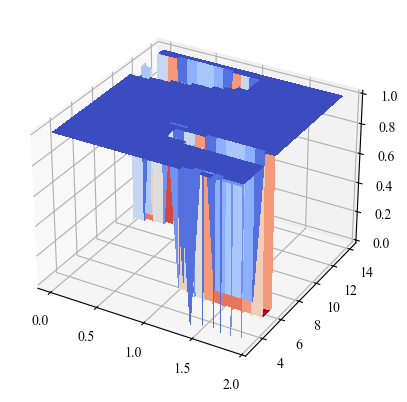

In [19]:
# Fundamental! latest certified! April 20th, 2021
import matplotlib.pyplot as plt
from tqdm import tqdm
epsilon_d = 0.1
epsilon_x = 0.05
gamma = args.gamma
T = 30
dt = 0.1
G, G_x, H_x, G_x0, H_x0, G_d, H_d, ego_traj, nominal_act, constraint_list, reach_list, success, success_time, num_vars, num_soc,cones, zero_sparse_matrix, reach_measures, reach_offsets, num_reach_check, prox_measures, prox_offsets = qp_reach_avoid_variables(T, dt,epsilon_x, epsilon_d, nx, nu, nd)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = np.arange(min_x, max_x, epsilon_d)
y = np.arange(min_y, max_y, epsilon_x)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V_qp = np.zeros((X.shape))
status_list = [[[] for i in range(size_x)] for j in range(size_y)]
for ii in tqdm(range(V_qp.shape[0])):
    for jj in range(V_qp.shape[1]):
        tmp_point = np.array([
            car1_x, car1_y, car1_vy, 
            X[ii,jj], Y[ii,jj], ego_v, ego_theta,
            car2_x, car2_y, car2_vy
        ])
        Done, tmp = qp_reach_avoid_checking(epsilon_x, epsilon_d, tmp_point, T, dt, G_x0,H_x0, H_x, H_d, G, num_soc,cones, num_vars,
                            prox_measures, prox_offsets, reach_measures, reach_offsets, zero_sparse_matrix, verbose = False)
        status_list[ii][jj] = tmp
        if Done == True:
            V_qp[ii,jj] = 1
        else:
            V_qp[ii,jj] = 0
        
surf = ax.plot_surface(X, Y, V_qp, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=False)


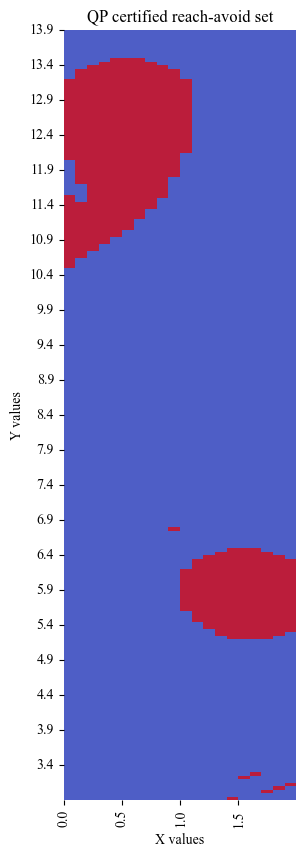

In [20]:
import seaborn as sns

x_interval = 5
y_interval = 10

fig, ax = plt.subplots( figsize=(3, 10))
Vqp_flipped = np.flipud(V_qp)
sns.heatmap(Vqp_flipped, annot=False, cmap=cm.coolwarm_r,alpha = 0.9, ax=ax,cbar=False,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))

ax.set_title('QP certified reach-avoid set')
ax.set_xlabel('X values')
ax.set_ylabel('Y values')

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval], 1))

ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [21]:
# Certification method 2: Lipschitz certification
certification_gamma = args.gamma

def beta(T, Lf,Ld, epsilon_x, epsilon_d):
    tmp = 0
    tmp = Lf**T * epsilon_x  + (1-Lf**(T))/(1-Lf)  *Ld* epsilon_d #* Lf
    return tmp *  certification_gamma**T

horizon = T
Lc = 20 # constraint Lipschitz constant
Lr = 10 # reward Lipschitz constant
Lf = 1.05125 # forward dynamics Lipschitz constant
epsilon_d = 0.1 # disturbance bound
epsilon_x = 0.05 # state bound
Ld = 0.1 # dynamics's Lipschitz constant on the disturbance

alphaC_list = np.zeros(horizon)
alphaR_list = np.zeros(horizon)
for t in range(horizon):
    alphaC_list[t] = Lc*beta(t, Lf,Ld, epsilon_x, epsilon_d) # TODO: integrate it into the online calibration!
    alphaR_list[t] = Lr*beta(t, Lf,Ld, epsilon_x, epsilon_d) # TODO: integrate it into the online calibration!


def calibrate_V(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    state_traj[:,0] = state
    env.reset(initial_state = state)    
    value_list = np.array([])
    constraint_list = np.array([])
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        # modify action
        action = np.array([action[0], action[1], 0, 0])
        tmp, rew, _, _, info = env.step(action)
        state_traj[:,t+1] = tmp
        print("constraint at time {}: {}".format(t, info["constraint"])) if verbose else None
        tmp_constraint = info["constraint"]*certification_gamma**t - alphaC_list[t]
        if tmp_constraint <= 0: # NOTE
            return 0
        constraint_list = np.append(constraint_list, tmp_constraint)
        tmp_value = np.min([ certification_gamma**t * rew - alphaR_list[t], 
                            np.min(constraint_list) ]) # TODO: program the empirical value function
        value_list = np.append(value_list, tmp_value)
        if tmp_value >= 0:
            return 1
    empirical_value = np.max(value_list)
    if verbose:
        print("value list: ", value_list)
        print("constraint list: ", constraint_list)
        print("empirical value list: ", empirical_value)
    return empirical_value



100%|██████████| 220/220 [00:15<00:00, 14.19it/s]


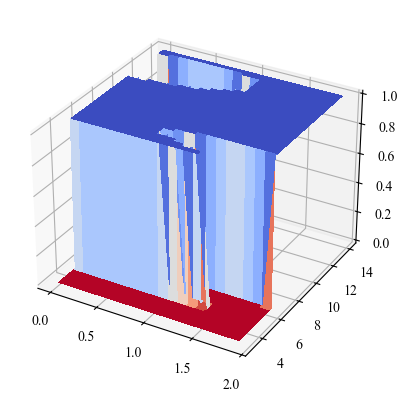

In [22]:
# plot the calibrated value function
from tqdm import tqdm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
size_x = len(x)
size_y = len(y)
V_lp = np.zeros((X.shape))

for ii in tqdm(range(V_lp.shape[0])):
    for jj in range(V_lp.shape[1]):
        tmp_point = torch.tensor([
            car1_x, car1_y, car1_vy, 
            X[ii,jj], Y[ii,jj], ego_v, ego_theta,
            car2_x, car2_y, car2_vy
        ])
        V_lp[ii,jj] = calibrate_V(env, tmp_point.numpy(), horizon, )
        
surf = ax.plot_surface(X, Y, V_lp, cmap=cm.coolwarm_r,linewidth=0, antialiased=False)

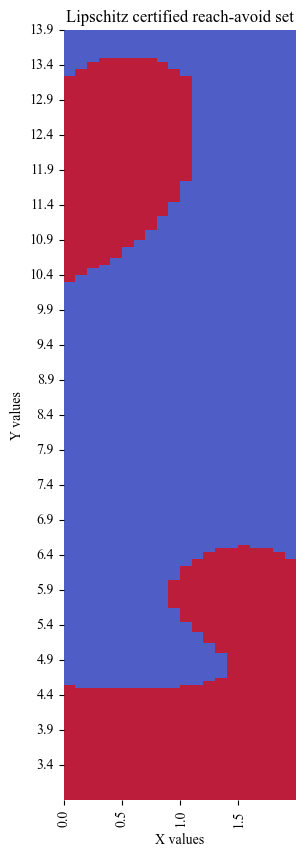

In [24]:
import seaborn as sns

x_interval = 5
y_interval = 10

fig, ax = plt.subplots(figsize=(3, 10))
Vlp_flipped = np.flipud(V_lp)
sns.heatmap(Vlp_flipped, annot=False, cmap=cm.coolwarm_r,cbar=False, alpha=0.9,
            ax=ax,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))



ax.set_title('Lipschitz certified reach-avoid set')
ax.set_xlabel('X values')
ax.set_ylabel('Y values')

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval], 1))
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


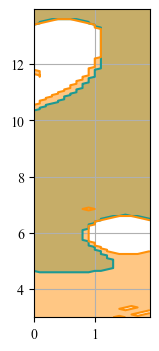

In [27]:
import matplotlib.colors as colors
plt.figure(figsize=(1.5, 4)
)
binary_V = np.zeros(V_lp.shape) # Lipschitz certified
binary_V[V_lp > 0] = 1
binary_Vqp = np.zeros(V_qp.shape) # SOCP certified
binary_Vqp[V_qp > 0] = 1
plt.contour(X,Y,binary_V, levels=[1 - 1e-6], colors = color_list[2])
plt.contour(X,Y,binary_Vqp, levels=[1 - 1e-6], colors = color_list[0])
plt.contourf(X,Y,binary_V, levels=[1 - 1e-6, 1], colors = color_list[2], alpha = 0.5, 
)

plt.contourf(X,Y,binary_Vqp,levels=[1 - 1e-6, 1], colors = color_list[0],alpha = 0.5, 
)
plt.grid()


In [29]:
"""
success rate is computed by recording the number of initial states that can be maintained within the target set for 50 steps
"""
from LCRL.data import Batch
from tqdm import tqdm

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

n_dim = env.observation_space.shape[0]
def roll_out_traj(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    
    state_traj[:,0] = state
    env.reset(initial_state = state)
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        rand_disturbance = np.random.uniform(low = -1, high = 1, size = (2,))
        action = np.array([action[0], action[1], rand_disturbance[0], rand_disturbance[1]])
        tmp, rew, _, _, info = env.step(action)
        
        state_traj[:,t+1] = tmp
        if rew > 0 and t<=horizon-2:
            if t>1 and verbose:
                print("success at time = {}!".format(t))
            return state_traj[:,:t+1], True

        if info["constraint"] < 0:
            print("constraint violated!") if verbose else None
            return state_traj[:,:t+1], False
            break
        
    return state_traj, False

num_samples = 100
sampled_states = np.zeros((n_dim,num_samples))
num_success = 0
horizon = 50
list_of_failure_states = []
list_of_success_states = []
high = [1, 18, 2, 
        2, 18, 2, np.pi*3/4,
        2, 8, 1]
low  = [0, 8, 0.5,
        0, 2, 0.5, np.pi/4,
        1.5, 2, 0.5]
# high = envs.initial_condition_high
# low = envs.initial_condition_low
for ii in tqdm(range(num_samples)):
    sampled_initial_state = np.random.uniform(low = low, high = high)
    tmp = envs.reset(initial_state = sampled_initial_state)
    sampled_states[:,ii] = tmp[0]
    while evaluate_V(sampled_states[:,ii]) < 0:
        sampled_initial_state = np.random.uniform(low = low, high = high)
        tmp = envs.reset(initial_state = sampled_initial_state)
        sampled_states[:,ii] = tmp[0]
    # import pdb; pdb.set_trace()
    traj, success = roll_out_traj(envs, sampled_states[:,ii], horizon, verbose = False)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(sampled_states[:,ii])
    else:
        list_of_failure_states.append(sampled_states[:,ii])
        continue
num_success/num_samples

 22%|██▏       | 22/100 [00:00<00:00, 216.89it/s]

success at time = 3!
success at time = 7!
success at time = 19!
success at time = 17!
success at time = 9!
success at time = 5!
success at time = 5!
success at time = 9!
success at time = 2!
success at time = 6!
success at time = 15!
success at time = 5!
success at time = 2!
success at time = 2!
success at time = 5!
success at time = 8!
success at time = 5!
success at time = 7!
success at time = 8!
success at time = 7!
success at time = 9!
success at time = 14!
success at time = 2!
success at time = 5!
success at time = 8!
success at time = 4!
success at time = 5!
success at time = 14!
success at time = 4!
success at time = 9!
success at time = 10!
success at time = 12!


 70%|███████   | 70/100 [00:00<00:00, 209.68it/s]

success at time = 18!
success at time = 10!
success at time = 6!
success at time = 4!
success at time = 23!
success at time = 13!
success at time = 3!
success at time = 8!
success at time = 8!
success at time = 5!
success at time = 19!
success at time = 9!
success at time = 6!
success at time = 5!
success at time = 25!
success at time = 10!
success at time = 4!
success at time = 8!
success at time = 5!
constraint violated!
success at time = 13!
success at time = 8!
success at time = 7!
success at time = 3!
success at time = 13!
success at time = 15!
success at time = 22!
success at time = 15!
success at time = 6!


100%|██████████| 100/100 [00:00<00:00, 209.71it/s]

success at time = 8!
success at time = 8!
success at time = 19!
success at time = 4!
success at time = 8!
success at time = 2!
success at time = 2!
success at time = 6!
success at time = 8!
success at time = 18!
success at time = 10!
success at time = 4!


0.99

success at time = 22!


100%|██████████| 220/220 [00:00<00:00, 944.06it/s]
/tmp/ipykernel_5527/508221598.py:49: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1], colors = "#80A8D6", alpha = 0.8,
100%|██████████| 23/23 [00:00<00:00, 46.09it/s]


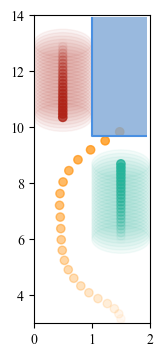

In [30]:
# draw animation of a rollout trajectory
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
from tqdm import tqdm
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'))
def target_set(env, X, Y, tmp_point = np.zeros(10)):
    reward = np.zeros((X.shape))
    for ii in tqdm(range(reward.shape[0])):
        for jj in range(reward.shape[1]):
            tmp_point[3], tmp_point[4] = X[ii,jj], Y[ii,jj]
            env.reset(initial_state = tmp_point)
            reward[ii,jj] = 1 if env.step([0,0,0,0,0,0])[1]>=0 else 0
    return reward
initial_state = np.array([0.7, 13, 1.,
                        1.7, 2, 1., np.pi/2,
                        1.7, 6, 1.])


initial_state = np.array([
    car1_x, car1_y, car1_vy,
    1.5, 3.0, ego_v, ego_theta,
    car2_x, car2_y, car2_vy
])
horizon = 200
traj, success = roll_out_traj(env, initial_state, horizon, verbose=True)
print("success: ", success)
fig, ax = plt.subplots(figsize=(1.5, 4))


# create an alpha list from 0.2 to 1
alpha_list = np.linspace(0.01, 0.8, traj.shape[1])
# reverse the alpha list
# reverse_alpha_list = alpha_list[::-1]
ax.set_xlim(( min_x, max_x))
ax.set_ylim((min_y, max_y))
# how can I make the previous frame disappear?
for j in tqdm(range(traj.shape[1])):
    ax.scatter(traj[0,j], traj[1,j], color=color_list[4], label = "car 1", alpha = alpha_list[j])
    ax.scatter(traj[3,j], traj[4,j], color=color_list[0], label = "Ego", alpha = alpha_list[j])
    ax.scatter(traj[7,j], traj[8,j], color=color_list[7], label = "car 3", alpha = alpha_list[j])
    ax.add_patch(plt.Circle((traj[0,j], traj[1,j]), 0.5, color=color_list[4], alpha = 0.05))
    ax.add_patch(plt.Circle((traj[7,j], traj[8,j]), 0.5, color=color_list[7], alpha = 0.05))
    if j == traj.shape[1]-1:
        x = np.arange(min_x, max_x, 0.05)
        y = np.arange(min_y, max_y, 0.05)
        X, Y = np.meshgrid(x, y)
        reward = target_set(envs, X, Y, traj[:,j])
        plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1], colors = "#80A8D6", alpha = 0.8, 
                    label = "target set"
                    # hatches=['//']
                    )
        plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = color_list[8])


